In [237]:
# Simulador de Filtros
# Autores: Ramiro Belsito y Ignacio Sammartino
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import sympy as sp
from sympy import log, symbols, solve
import math
import sys

In [238]:


def ENG( valor: float, unidad: str) -> str:
    """
    Convierte un valor de resistencia o cself.Apacitancia a notación de ingeniería.
    
    Parámetros:
    - valor: El valor numérico (float)
    - unidad: 'Ohm' para resistencias o 'F' para cself.Apacitores

    Retorna:
    - str con el valor en notación de ingeniería (ej. 4.7 kOhm, 10 nF)
    """
    prefijos = {
        -12: 'p',
        -9: 'n',
        -6: 'µ',
        -3: 'm',
         0: '',
         3: 'k',
         6: 'M',
         9: 'G',
    }

    if valor == 0:
        return f"0 {unidad}"
    
    exponente = int(math.floor(math.log10(abs(valor)) // 3 * 3))
    exponente = max(min(exponente, 9), -12)  # limitar a prefijos comunes
    valor_normalizado = valor / (10 ** exponente)
    
    prefijo = prefijos.get(exponente, f"e{exponente}")
    
    return f"{valor_normalizado:.3g} {prefijo}{unidad}"

def ingresar_valor(value : str) -> float:
    try: 
        return float(value)
    except ValueError:
        if (re.search(r"(\d+(\.\d+)?)([kMG]?)", value)):
            match = re.search(r"(\d+(\.\d+)?)([kMG]?)", value)
            if match:
                num = float(match.group(1))
                if match.group(3) == 'k':
                    return num * 1e3
                elif match.group(3) == 'M':
                    return num * 1e6
                elif match.group(3) == 'G':
                    return num * 1e9
        else:
            print("Error: Unidad no válida")
            check = False
            exit(1)

def get_zeros_and_poles(F):
    """
    Función que calcula los ceros y los polos de una función transferencia
    
    :param F: función transferencia como expresión de sympy

    :returns: ceros y polos de la función transferencias
    """

    #Obtenemos  el numerador y denominador de la expresión
    num = sp.fraction(F)[0]
    den = sp.fraction(F)[1]
    

    #Obtenemos los coeficientes del numerador y denominador. Los ifs son para los casos donde el numerador o denominador son de orden 1. 

    
    #Si no tiene ceros
    if num.is_number:
        num_coeffs = num
    #Si tiene ceros
    else:
        num_coeffs = sp.Poly(num).all_coeffs()

    #Si no tiene polos

    if den.is_number:
    
        den_coeffs = den
    #Si tiene polos
    else:
        den_coeffs = sp.Poly(den).all_coeffs()


    #Para mejor manejo vamos a pasar estos coeficientes a un tipo de arreglo de numpy (confíen)
    num_coeffs = np.array(num_coeffs, dtype = float)
    den_coeffs = np.array(den_coeffs, dtype = float)

    

    #Obtenemos las raíces de esos polinomios. 
    #Esto lo vamos a hacer a través de scipy, que tiene una función que a partir de los coeficientes del numerador y denominador, te da los polos y ceros
    
    pz = signal.tf2zpk(num_coeffs,den_coeffs)

    #pz es una arreglo [ceros, polos, ganancia]

    zeros = pz[0]
    poles = pz[1]

    return zeros, poles

def plot_pz_map(zeros, poles):
    """
    Función que grafica el PZ map diagrama de polos y ceros. 
        
    :param zeros: lista de ceros
    :param poles: lista de polos

    """
    plt.figure(figsize=(8, 6))
    zeros_parte_real = np.real(zeros)
    zeros_parte_imaginaria =  np.imag(zeros)
    plt.scatter(zeros_parte_real,zeros_parte_imaginaria, marker='o', color='b')

    poles_parte_real = np.real(poles)
    poles_parte_imaginaria =  np.imag(poles)
    plt.scatter(poles_parte_real,poles_parte_imaginaria, marker='x', color='b')

    #Pueden cambiar este límite como quieram
    plt.xlim([-1.6, 1.6])

    plt.xlabel('$\\sigma$')
    plt.ylabel('$j\\omega$')

    plt.grid()
    plt.show()

def plot_bode(mag, w):
    """"
    Función que plotea el módulo de la respuesta en frecuencia de un sistema.

    :param mag: valores de magnitud
    :param w: valores de frecuencia

    """
    
    fig, ax = plt.subplots(figsize=(7, 5))

    #Estos valores los pueden cambiar
    Gp = 0.8
    Ga = 0.0316
    wa = 1.5 
    wp = 1


    ax.plot(w, mag)
    ax.add_patch(plt.Rectangle((0,1),wp,-(1-Gp),facecolor='green',alpha=0.2))
    ax.add_patch(plt.Rectangle((wa,0),1,Ga,facecolor='red',alpha=0.2))
    plt.xlim([0, 2])
    plt.ylim([0, 1.05])
    plt.ylabel('Módulo [v/v]')
    plt.xlabel('$\\omega$  [rad/s]')
    plt.grid()
    plt.title('Módulo de la respuesta en frecuencia')
    plt.show()

    
class Filtro:
    TipoDeFiltro = ""
    wpmin = 0
    wpmax = 0
    wamin = 0
    wamax = 0
    wp = 0
    wa = 0
    f0 = 0
    Ap = 0
    Aa = 0
    waN = 0
    wpN = 0
    funcionDeAprox = ""
    def obtener_filtro(self):
        self.TipoDeFiltro = input("Ingrese el tipo de filtro (PasaBajo, Pasself.Aalto, PasaBanda, RechazaBanda): ")

        if re.search("alto", self.TipoDeFiltro, re.IGNORECASE) or re.search("hp", self.TipoDeFiltro, re.IGNORECASE):
            self.TipoDeFiltro = "HP"
        elif re.search("bajo", self.TipoDeFiltro, re.IGNORECASE) or re.search("lp", self.TipoDeFiltro, re.IGNORECASE):
            self.TipoDeFiltro = "LP"
        else:
            if re.search("rechaza", self.TipoDeFiltro, re.IGNORECASE) or re.search("br", self.TipoDeFiltro, re.IGNORECASE):
                self.TipoDeFiltro = "BR"
            elif re.search("banda", self.TipoDeFiltro, re.IGNORECASE) or re.search("bp", self.TipoDeFiltro, re.IGNORECASE):
                self.TipoDeFiltro = "BP"
            else:
                print("Error: Tipo de filtro no reconocido.")
                exit(1)

        check = True

        if self.TipoDeFiltro == "LP":
            self.wp = np.pi*2*ingresar_valor(input("Ingrese la frecuencia de paso (Hz): "))
            self.wa = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia de rechazo (Hz): "))
            self.Ap = float(input("Ingrese la atenuación en banda de paso (dB): "))
            self.Aa = float(input("Ingrese la atenuación en banda de rechazo (dB): "))
            self.waN = self.wa/self.wp
            self.wpN = 1
            if not ((self.wp < self.wa) and (self.Ap < self.Aa)):
                print("Error: Los parametros no cumplen con la condición de diseño.")
                check = False
            else:
                print("wp = ", ENG(self.wp, "(rad/s)"))
                print("wa = ", ENG(self.wa, "(rad/s)"))
                print("Ap = ", self.Ap, "dB")
                print("Aa = ", self.Aa, "dB")
                print("Las frecuencias cumplen con la condición de diseño.")
                
        elif self.TipoDeFiltro == "HP":
            self.wp = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia de paso (Hz): "))
            self.wa = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia de rechazo (Hz): "))
            self.Ap = float(input("Ingrese la atenuación en banda de paso (dB): "))
            self.Aa = float(input("Ingrese la atenuación en banda de rechazo (dB): "))
            self.waN = self.wp/self.wa
            self.wpN = 1
            if not ((self.wa < self.wp) and (self.Ap < self.Aa)):
                print("Error: Los parametros no cumplen con la condición de diseño.")
                check = False
            else:
                print("wp = ", ENG(self.wp, "(rad/s)"))
                print("wa = ", ENG(self.wa, "(rad/s)"))
                print("Ap = ", self.Ap, "dB")
                print("Aa = ", self.Aa, "dB")
                print("Las frecuencias cumplen con la condición de diseño.")
        elif self.TipoDeFiltro == "BP":
            self.wamin = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia de rechazo inferior (Hz): "))
            self.wpmin = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia de paso inferior (Hz): "))
            self.f0 = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia central (Hz): "))
            self.wpmax = self.f0**2 / self.wpmin
            self.wamax = self.f0**2 / self.wamin
            self.Ap = float(input("Ingrese la atenuación en banda de paso (dB): "))
            self.Aa = float(input("Ingrese la atenuación en banda de rechazo (dB): "))
            B = self.wpmax - self.wpmin
            BA = self.wamax - self.wamin
            self.waN = BA/B
            self.wpN = 1
            if not ((self.wamin < self.wpmin < self.f0 < self.wpmax < self.wamax) and (self.Ap < self.Aa)):
                print("Error: Los parametros no cumplen con la condición de diseño.")
                check = False
            else:
                print("wamin = ", ENG(self.wamin, "(rad/s)"))
                print("wpmin = ", ENG(self.wpmin, "(rad/s)"))
                print("f0 = ", ENG(self.f0, "(rad/s)"))
                print("wpmax = ", ENG(self.wpmax, "(rad/s)"))
                print("wamax = ", ENG(self.wamax, "(rad/s)"))
                print("Ap = ", self.Ap, "dB")
                print("Aa = ", self.Aa, "dB")
                print("Las frecuencias cumplen con la condición de diseño.")
        elif self.TipoDeFiltro == "BR":
            self.wpmin = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia de paso inferior (Hz): "))
            self.wamin = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia de atenuacion inferior (Hz): "))
            self.f0 = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia central (Hz): "))
            self.wpmax = self.f0**2 / self.wpmin
            self.wamax = self.f0**2 / self.wamin
            self.Ap = float(input("Ingrese la atenuación en banda de paso (dB): "))
            self.Aa = float(input("Ingrese la atenuación en banda de rechazo (dB): "))
            B = self.wpmax - self.wpmin
            BA = self.wamax - self.wamin
            self.waN = B/BA
            self.wpN = 1
            if not ((self.wpmin < self.wamin < self.f0 < self.wamax < self.wpmax) and (self.Ap < self.Aa)):
                print("Error: Las frecuencias no cumplen con la condición de diseño.")
                check = False
            else:
                print("wpmin = ", ENG(self.wpmin, "(rad/s)"))
                print("wamin = ", ENG(self.wamin, "(rad/s)"))
                print("f0 = ", ENG(self.f0, "(rad/s)"))
                print("wamax = ", ENG(self.wpmax, "(rad/s)"))
                print("wpmax = ", ENG(self.wamax, "(rad/s)"))
                print("Ap = ", self.Ap, "dB")
                print("Aa = ", self.Aa, "dB")
                print("Las frecuencias cumplen con la condición de diseño.")

        print("waN = ", ENG(self.waN, "(rad/s)"))
        print("wpN = ", ENG(self.wpN, "(rad/s)"))
        self.Ap = -self.Ap
        self.Aa = -self.Aa

        if not check:
            sys.exit(1)
        return
    def obtenerFuncAprox(self):
        self.funcionDeAprox = input("Ingrese la función de aproximación (Butterworth, Chebyshev I, Chebyshev II): ")
        if re.search(r'butter(?:worth)?', self.funcionDeAprox, re.IGNORECASE):
            self.funcionDeAprox = "Butter"
            self.funcionDeAprox = "Butter"
        elif re.search(r'cheb(y|i|í|bi|yshev|yschev|yshef)?\s*(i|1)', self.funcionDeAprox, re.IGNORECASE):
            self.funcionDeAprox = "Cheby I"
        elif re.search(r'cheb(y|i|í|bi|yshev|yschev|yshef)?\s*(ii|2)', self.funcionDeAprox, re.IGNORECASE):
            self.funcionDeAprox = "Cheby II"
        else:
            print("Error: Función de aproximación no reconocida.")
            exit(1)
    def plotPlantillaNormalizada(self, H):
        AaLineal = (10**(self.Aa/20))
        ApLineal = (10**(self.Ap/20))
        xlim = self.waN * 2
        ylim = 1.1
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.add_patch(plt.Rectangle((0, 0), self.wpN, ApLineal, color='red', alpha=0.3))
        ax.add_patch(plt.Rectangle((self.waN, AaLineal), xlim, ylim, color='red', alpha=0.3))
        ax.plot([0, self.wpN], [ApLineal, ApLineal], 'r--', label=f'Gp = {ApLineal} veces')
        ax.plot([self.wpN, self.wpN], [0, ApLineal], 'r--', label=f'wpN = {self.wpN} (rad/s)')
        ax.plot([self.waN, self.waN], [AaLineal, ylim], 'r--', label=f'waN = {self.waN} (rad/s)')
        ax.plot([self.waN, xlim], [AaLineal,AaLineal], 'r--', label=f'Ga = {AaLineal} veces')
        
        ax.set_xlim(0, xlim)
        ax.set_ylim(0, ylim)
        w_axis = np.linspace(0, xlim, 1000)
        w_axis, mag, phase = signal.bode(H, w_axis)
        mag_en_veces = 10**(mag/20)
        ax.plot(w_axis, mag_en_veces, 'b-', label='Respuesta en frecuencia')
        plt.title(f"Plantilla LP Normalizada del filtro {self.TipoDeFiltro}")
        plt.xlabel("Frecuencia Normalizada (rad/s)")
        plt.ylabel("Ganancia (dB)")
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()
        return
    def plotPlantillaArbitraria(self):
        match self.TipoDeFiltro:
            case "LP":
                xlim = self.wa * 2
                ylim = self.Aa*1.25
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.invert_yaxis()
                ax.add_patch(plt.Rectangle((self.wp, xlim), ylim, self.Ap, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((0, self.wa), self.Aa,0, color='red', alpha=0.3))
                ax.plot([0, self.wp], [self.Ap, self.Ap], 'r--', label=f'Ap = {self.Ap} dB')
                ax.plot([self.wp,self.wp], [ylim, self.Ap], 'r--', label=f'wp = {self.wpN} (rad/s)')
                ax.plot([self.wa,self.wa], [0, self.Aa], 'r--', label=f'wa = {self.waN} (rad/s)')
                ax.plot([self.wa, xlim], [self.Aa, self.Aa], 'r--', label=f'Aa = {self.Aa} dB')
                
                ax.set_xlim(0, xlim)
                ax.set_ylim(ylim, 0)
                plt.title(f"Plantilla de {self.TipoDeFiltro}")
                plt.xlabel("Frecuencia (rad/s)")
                plt.ylabel("Atenuación (dB)")
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                plt.show()
            case "HP":
                xlim = self.wa * 2
                ylim = self.Aa*1.25
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.invert_yaxis()
                ax.add_patch(plt.Rectangle((0, 0), self.wa, self.Aa, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.wp, self.Ap), xlim - self.wp, ylim, color='red', alpha=0.3))
                ax.plot([self.wp, xlim], [self.Ap, self.Ap], 'r--', label=f'Ap = {self.Ap} dB')
                ax.plot([self.wp,self.wp], [ylim, self.Ap], 'r--', label=f'wp = {self.wpN} (rad/s)')
                ax.plot([self.wa,self.wa], [0, self.Aa], 'r--', label=f'wa = {self.waN} (rad/s)')
                ax.plot([0, self.wa], [self.Aa, self.Aa], 'r--', label=f'Aa = {self.Aa} dB')
                
                ax.set_xlim(0, xlim)
                ax.set_ylim(ylim, 0)
                plt.title(f"Plantilla de {self.TipoDeFiltro}")
                plt.xlabel("Frecuencia (rad/s)")
                plt.ylabel("Atenuación (dB)")
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                plt.show()
            case "BP":
                xlim = self.wamax * 2
                ylim = self.Aa*1.25
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.invert_yaxis()
                ax.add_patch(plt.Rectangle((0,0), self.wamin, self.Aa, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.wpmin, self.Ap), self.wpmax - self.wpmin, ylim, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.wamax, 0), xlim, self.Aa, color='red', alpha=0.3))
                ax.plot([self.wpmin, self.wpmax], [self.Ap, self.Ap], 'r--', label=f'Ap = {self.Ap} dB')
                ax.plot([0,self.wamin], [self.Aa, self.Aa], 'r--', label=f'Aa = {self.Aa} dB')
                ax.plot([self.wamax, xlim], [self.Aa, self.Aa], 'r--')
                ax.plot([self.wamin, self.wamin], [0, self.Aa], 'r--', label=f'wa- = {self.wamin} (rad/s)')
                ax.plot([self.wpmin, self.wpmin], [ylim, self.Ap], 'r--', label=f'wp- = {self.wpmin} (rad/s)')
                ax.plot([self.wpmax, self.wpmax], [ylim, self.Ap], 'r--', label=f'wp+ = {self.wpmax} (rad/s)')
                ax.plot([self.wamax, self.wamax], [0, self.Aa], 'r--', label=f'wa+ = {self.wamax} (rad/s)')

                ax.plot([self.f0, self.f0], [0, ylim], 'b--', label=f'f0 = {self.f0} (rad/s)')
                ax.set_xlim(0, xlim)
                ax.set_ylim(ylim, 0)
                plt.title(f"Plantilla de {self.TipoDeFiltro}")
                plt.xlabel("Frecuencia (rad/s)")
                plt.ylabel("Atenuación (dB)")
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                plt.legend()
                plt.show()
            case "BR":
                xlim = self.wpmax * 2
                ylim = self.Aa*1.25
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.invert_yaxis()
                ax.add_patch(plt.Rectangle((0,self.Ap), self.wpmin, ylim, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.wamin,0), self.wamax - self.wamin, self.Aa, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.wpmax, self.Ap), xlim, ylim, color='red', alpha=0.3))
                ax.plot([0, self.wpmin], [self.Ap, self.Ap], 'r--', label=f'Ap = {self.Ap} dB')
                ax.plot([self.wamin, self.wamax], [self.Aa, self.Aa], 'r--', label=f'Aa = {self.Aa} dB')
                ax.plot([self.wpmax, xlim], [self.Ap, self.Ap], 'r--')
                ax.plot([self.wpmin, self.wpmin], [ylim, self.Ap], 'r--', label=f'wp- = {self.wpmin} (rad/s)')
                ax.plot([self.wamin, self.wamin], [0, self.Aa], 'r--', label=f'wa- = {self.wamin} (rad/s)')
                ax.plot([self.wamax, self.wamax], [0, self.Aa], 'r--', label=f'wa+ = {self.wamax} (rad/s)')
                ax.plot([self.wpmax, self.wpmax], [ylim, self.Ap], 'r--', label=f'wp+ = {self.wpmax} (rad/s)')

                ax.plot([self.f0, self.f0], [0, ylim], 'b--', label=f'f0 = {self.f0} (rad/s)')
                
                ax.set_xlim(0, xlim)
                ax.set_ylim(ylim, 0)
                plt.title(f"Plantilla de {self.TipoDeFiltro}")
                plt.xlabel("Frecuencia (rad/s)")
                plt.ylabel("Atenuación (dB)")
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                plt.legend()
                plt.show()
    

filtro = Filtro()
filtro.obtener_filtro()


wamin =  4.57 k(rad/s)
wpmin =  13.6 k(rad/s)
f0 =  15.1 k(rad/s)
wpmax =  16.8 k(rad/s)
wamax =  49.8 k(rad/s)
Ap =  1.0 dB
Aa =  40.0 dB
Las frecuencias cumplen con la condición de diseño.
waN =  14.2 (rad/s)
wpN =  1 (rad/s)


In [239]:



def get_chebyshev_poly (n, show = False):
    """ 
    Función que devuelve el polinomio de chebyshev de orden n

    :param n: orden

    :returns el polinomio como expresión de sympy
    """
    x = sp.symbols('x')

    C = [0] *(n + 1)  #Genera una lista todas con ceros de tamaño orden + 1

    #Polinomios iniciales de orden 0 y 1
    C[0] = 1
    C[1] = x

    #Forma recursiva
    
    for z in range (2,len(C)):
        C[z] = 2*x*C[z-1] - C[z-2]
        if show:
            display(f'Orden {z}: ')
            display(C[z])

    return C[n], x

def funcionDeAproximacionButter(filtro: Filtro):
    # Hallar xi
    ApLineal = 10**(filtro.Ap/20)
    AaLineal = 10**(filtro.Aa/20)
    xi = sp.symbols('xi')
    xi = sp.solve(1/(1+xi**2) - ApLineal**2, xi)
    xi = xi[1] # xi es el valor positivo
    # Hallar n
    n = sp.symbols('n')
    func = (1/(1+(xi**2)*((filtro.waN)**(2*n))))- AaLineal**2
    n = sp.solve(func, n)
    nCalc = math.ceil(abs(n[0]))
    print("n = ", nCalc)
    # Hallar w0
    w = sp.symbols('w')
    G2 = (1/(1+(xi**2)*((w)**(2*nCalc))))
    display(G2)
    # evaluar en w = s/j 
    s = sp.symbols('s')
    G2 = G2.subs(w, s/sp.I)
    display(G2)
    zeros, poles = get_zeros_and_poles(G2)
    polesImplementables = []
    for p in poles:
        if sp.re(p) <= 0:
            polesImplementables.append(p)
    print("Ceros: ", zeros)
    print("Polos: ", polesImplementables)
    gain = np.cumprod(polesImplementables)[-1]*(1)
    H = signal.ZerosPolesGain(zeros, polesImplementables, gain)
    plot_pz_map(zeros, polesImplementables)
    return H

def funcionDeAproximacionChebyshev1(filtro: Filtro):
    ApLineal = 10**(filtro.Ap/20)
    AaLineal = 10**(filtro.Aa/20)
    x = sp.symbols('x')
    s = sp.symbols('s')
    w = sp.symbols('w')
    xi = sp.symbols('xi')
    p = sp.symbols('p') # Polinomio de chebyshev
    n = sp.symbols('n') # Orden del polinomio
    G = 1/(1+(xi*p)**2)
    display(G)
    G_xi = G.subs(p, 1)
    eq_xi = sp.Eq(G_xi, ApLineal**2)
    sol_xi = sp.solve(eq_xi)
    sol_xi = sol_xi[1] # xi es el valor positivo
    G_xi = G.subs(xi, sol_xi)
    display(G_xi)
    CumplePlantilla = False
    i = 0
    while (not CumplePlantilla):
        G_xi = G.subs(xi, sol_xi)
        if i == 0:
            cheby = 1
        elif i == 1:
            cheby = w
        else:
            cheby, x = get_chebyshev_poly(i, show=False)
            cheby = cheby.subs(x,w)
        G_xi = G_xi.subs(p, cheby)
        G_n = G_xi.subs(w, filtro.waN)
        if (G_n < AaLineal**2):
            CumplePlantilla = True
            n = i
        else:
            i += 1
    print("Orden: ", n)
    print("G_n: ", G_n)
    Gs = G_xi.subs(w, s/sp.I) #sp.I es el número imaginario
    display(Gs)
    zeros, poles = get_zeros_and_poles(Gs)
    polesImplementables = []
    for p in poles:
        if sp.re(p) <= 0:
            polesImplementables.append(p)
    print("Ceros: ", zeros)
    print("Polos: ", polesImplementables)
    plot_pz_map(zeros, polesImplementables)
    if n%2:
        gain = np.cumprod(polesImplementables)[-1]*(1)  #Magic number?? Cómo es que a veces va Gp y otras no...
    else:
        gain = np.cumprod(polesImplementables)[-1]*(ApLineal) #Magic number?? Cómo es que a veces va Gp y otras no...
    H = signal.ZerosPolesGain(zeros, polesImplementables, gain)
    return H

    




Función de aproximación: Cheby I


1/(p**2*xi**2 + 1)

1/(0.258925411794166*p**2 + 1)

Orden:  2
G_n:  2.38901961709975e-5


1/(0.258925411794166*(-2*s**2 - 1)**2 + 1)

Ceros:  []
Polos:  [(-0.5488671642819645+0.8951285740199139j), (-0.5488671642819645-0.8951285740199139j)]


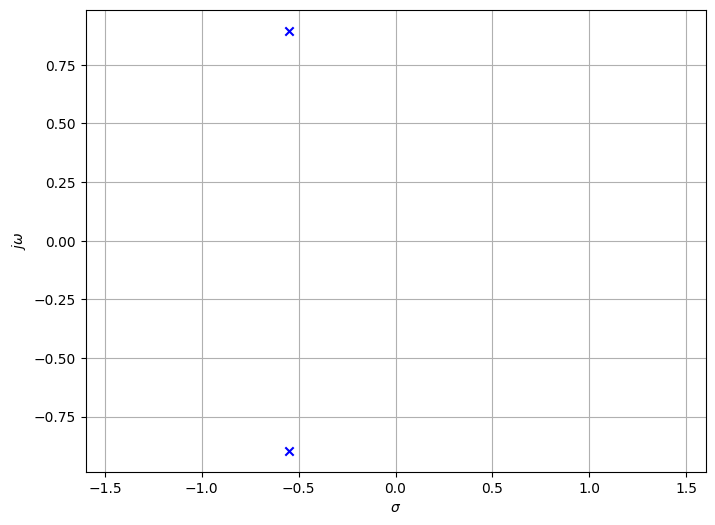

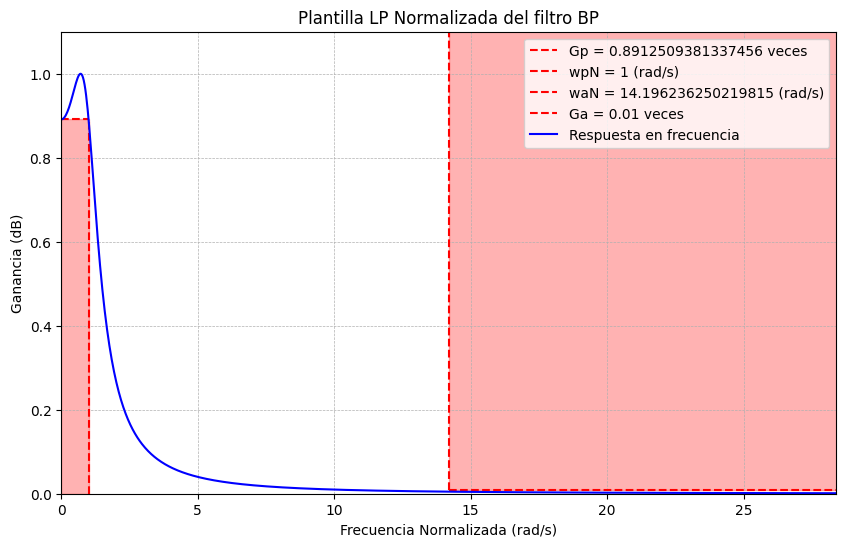

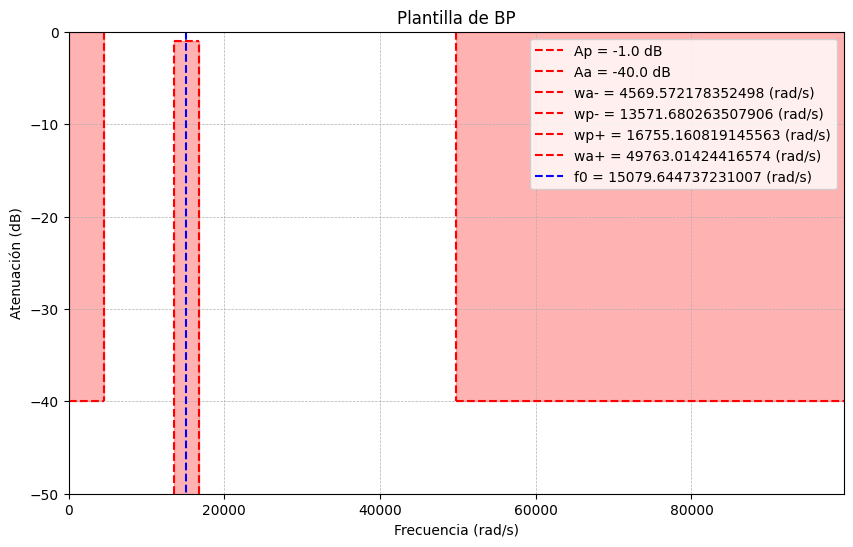

In [241]:
filtro.obtenerFuncAprox()
print(f"Función de aproximación: {filtro.funcionDeAprox}")
if filtro.funcionDeAprox == "Butter":
    H = funcionDeAproximacionButter(filtro)
elif filtro.funcionDeAprox == "Cheby I":
    H = funcionDeAproximacionChebyshev1(filtro)
elif filtro.funcionDeAprox == "Cheby II":
    print("Chebyshev II no implementado")


filtro.plotPlantillaNormalizada(H)
filtro.plotPlantillaArbitraria()

